# Decision Tree for Sequences

In [1]:
from load_dataset import load_dataset

from gini import * #Gini, improvement_gini
from projected_dataset import project_dataset
from upper_bound import * #upper_bound, split_node
from DiscoverPatternHighestGini import DPH
from BestTree import * #majority, BT
from PessimisticErrorPruning import * #node_error, subtree_error, standard_error, PEP
from SeqDT import * #SeqDT, sequences_per_class, calculate_tree_depth

from Representation import plot_tree

from ModelEvaluation import * #compute_metrics, predict_sequence, evaluate_model, evaluate_dataset

In [2]:
dataset = load_dataset("Datasets/dataset_paper.txt")
print(dataset)

Classes found in dataset:  ['+1', '-1']
[(['b', 'a', 'b', 'c', 'd'], '+1'), (['c', 'a', 'b', 'e'], '+1'), (['a', 'd', 'e', 'c', 'b'], '+1'), (['a', 'd', 'e', 'c', 'b'], '-1'), (['a', 'd', 'e', 'c', 'b'], '-1'), (['d', 'b', 'd', 'b'], '-1'), (['c', 'a', 'e'], '-1')]


## Gini index

The Gini coefficient measures the probability of a particular variable being wrongly classified when it is randomly chosen, ranging from 0 (pure: all samples belong to one class) to 1 (maximum impurity: uniform class distribution)

$Gini(y(T)) = 1 - \sum_{i=1}^d p_i^2$

where $p_i$ is the proportion of samples in node $T$ belonging to class $i$, and $d$ is the number of classes.

In [3]:
print(Gini(extraction_labels(dataset)).round(2))

0.49


## Improvement Gini

The Gini Improvement evaluates the discriminative ability of candidate split features $P$ for splitting node $T$. 

$I(T, P, g) = Gini(y(T)) - \frac{|T^g_P|}{|T|} Gini(y(T^g_P)) - \frac{|T^g_{\neg P}|}{|T|} Gini(y(T^g_{\neg P}))$

where $T^g_P$ contains sequences matching pattern $P$ under the gap constraint, 
and $T^g_{\neg P}$ contains the remaining sequences. Higher values indicate 
better class separation.

In [4]:
T_P, T_nP = split_node(dataset, ['c', 'a'], 1)
print(improvement_gini(extraction_labels(dataset), T_P, T_nP).round(5))

0.00408


## Projected dataset

The projected dataset is the subset of the given dataset obtained by taking, for each sequence that contains a given feature, the suffix that starts right after the last element of the feature. Each suffix keeps the original class label, and this reduced dataset is then used to search for possible extensions of the feature more efficiently.

In [5]:
print(project_dataset(dataset, ['c','a'], 1))

[(['b', 'e'], '+1'), (['e'], '-1')]


## Upper Bound
Theorem 1: 
Given a pattern $P$ and a constant $c$, if 

$UB(P) = max{I(x₁(T_P), 0, ..., 0), I(0, x₂(T_P), 0, ..., 0), ..., I(0, 0, ..., xₐ(T_P))} ≤ c$, 

then for all super-patterns $J ⊇ P: I(x(T_J)) ≤ c$.

For each class $i$, we create an ideal vector where only the count of class $i$ is preserved and all other classes are set to zero, then compute the improvement for this ideal case. The maximum among all these ideal improvements serves as an upper bound for any super-pattern of $P$. This allows the algorithm to safely prune patterns and their extensions when the upper bound is lower than the best improvement found so far, significantly reducing the search space.

In [6]:
print(upper_bound(dataset, ['c','a']).round(3))

0.109


## Extending Patterns

Collects unique symbols from the projected dataset and evaluates each potential pattern extension by computing its Gini improvement on the original dataset. Symbols are sorted by decreasing Gini improvement to enable early pruning of suboptimal patterns through upper bound testing.

In [7]:
P = ['c', 'a']
g = 0
SubT = project_dataset(dataset, P, g)
        
print("Projected dataset SubT:", SubT)

item_improvements = []

# Get all unique items in the projected dataset - ALPHABET
alphabet = set()
for seq, label in SubT:
    for item in seq:
        alphabet.add(item)
        
alphabet = sorted(alphabet)
        
print("Alphabet:", alphabet)

for item in alphabet:
    P_new = P + [item]
    T_P, T_nP = split_node(dataset, P_new, g)
    print(f'T_P: {T_P}, gini = {Gini(T_P)}')
    print(f'T_nP: {T_nP}, gini = {Gini(T_nP)}')
    
    if len(T_P) == 0:
        continue
        
    improvement = improvement_gini(extraction_labels(dataset), T_P, T_nP)
    item_improvements.append((improvement, item, P_new))
    print('Improvement', round(improvement, 3), 'of item', item, ', considering pattern', P_new)
    print('\n')

# Sort by improvement 
item_improvements.sort(key=lambda x: x[0], reverse=True)
print('items sorted:', item_improvements)


Projected dataset SubT: [(['b', 'e'], '+1'), (['e'], '-1')]
Alphabet: ['b', 'e']
T_P: ['+1'], gini = 0.0
T_nP: ['+1', '+1', '-1', '-1', '-1', '-1'], gini = 0.4444444444444444
Improvement 0.109 of item b , considering pattern ['c', 'a', 'b']


T_P: ['+1', '-1'], gini = 0.5
T_nP: ['+1', '+1', '-1', '-1', '-1'], gini = 0.48
Improvement 0.004 of item e , considering pattern ['c', 'a', 'e']


items sorted: [(np.float64(0.10884353741496611), 'b', ['c', 'a', 'b']), (np.float64(0.004081632653061329), 'e', ['c', 'a', 'e'])]


## Discover the Pattern with the Highest Gini Improvement (DPH)

The DPH algorithm searches for the most discriminative sequential pattern for splitting a node using a branch-and-bound strategy with a priority queue ordered by Gini improvement.

Each candidate pattern is checked against the upper bound; if it fails, the pattern and its extensions are pruned. Otherwise, a projected dataset is built, from which the reduced alphabet is obtained by collecting the unique symbols that appear in the suffix sequences. This reduced alphabet defines the feasible extensions of the current pattern. Each extension is evaluated by splitting the original dataset under the gap constraint and computing its Gini improvement.

If the improvement exceeds the current maximum, the best pattern and score are updated, and the extension is added to the queue if it satisfies the length and upper bound conditions.

The search terminates when the queue is empty, ensuring discovery of the optimal pattern within the maximum length constraint.

In [8]:
DPH(dataset, g=1, maxL=2)

(['a', 'b'], np.float64(0.261224))

## SeqDT

The SeqDT algorithm performs sequence classification in two stages.

First, it uses the Best Tree (BT) procedure to build an initial decision tree by recursively selecting discriminative sequential patterns with DPH and splitting nodes until stopping criteria are reached. This produces a tree that maximizes discrimination on training data.

In BT, each node is evaluated for purity using the Gini index.
If the node is sufficiently pure, it becomes a leaf with the majority class.
Otherwise, DPH finds the best splitting pattern, and the dataset is divided into sequences that contain the pattern and those that do not, under the gap constraint.
Recursion continues unless stopping criteria are triggered: too small improvement, too few samples in a child, or exceeding maximum depth.

Optionally, SeqDT applies Pessimistic Error Pruning (PEP) to remove subtrees that do not improve generalization, replacing them with leaves when appropriate.

In [9]:
print(sequences_per_class(dataset))

{'+1': 3, '-1': 4}


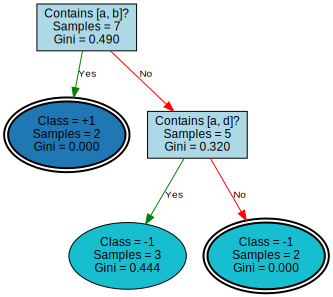

In [10]:
tree = SeqDT(dataset, g = 1, maxL = 3, pru = False, epsilon= 0.15, minS = 0, minN = 2, maxD= 0)

dot = plot_tree(tree)
dot

## Pessimistic Error Pruning (PEP)

Pessimistic Error Pruning (PEP) is a post-pruning method for decision trees that aims to reduce complexity and prevent overfitting by removing branches that don't improve the model's error rate on unseen data.
The Pessimistic Error Pruning algorithm is a top-down pruning algorithm.

For each node t, we calculate the following:

- The error of the node, $e(t)$: is calculated as the sum of misassigned samples (i.e., samples that were not assigned to the majority class) plus a continuity correction of 1/2 in the case of binary decisions. We do this to counteract a bias that can arise when the same set of samples is used for both tree construction and pruning.

$e(t)$ = misclassified_samples + 0.5 (continuity correction)

- The error of the subtree of the node, $e(T_t)$: is calculated as the sum of the errors of all the leaves following node t (including continuity corrections).

$e(T_t)$ = sum of errors of all reachable leaf nodes

- The standard error is now calculated from these two results and $n(t)$, which describes the number of samples in node $t$

$SE(e(T_t)) = \sqrt{\frac{e(T_t)(n(t) - e(T_t))}{n(t)}}$


Pruning occurs when the sum of the standard error and the error of the subtree is greater than or equal to the error of the node. This happens because node t, as a leaf node, makes fewer errors than the subtree.

$e(t) ≤ e(Tt) + SE$

(<https://lamarr-institute.org/blog/pruning-algorithms-mep-pep/>)

n_samples = 7, e(t) = 3.5, e(Tt) = 2.5, standard error = 1.27
Pruned


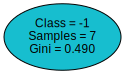

In [11]:
pru = PEP(tree)
dot_pruned = plot_tree(pru)
dot_pruned

## Performance metrics

Classification performance is evaluated with two complementary metrics. 
- Accuracy measures the overall proportion of correctly classified sequences, but can be misleading when class distributions are imbalanced. 
- G-mean is the geometric mean of class-specific recall rates, offering a balanced view of performance across all classes. Unlike accuracy, G-mean is highly sensitive to misclassification of minority classes: if any class has zero recall, the overall score drops to zero.

In [12]:
result = evaluate_dataset(dataset, g=1, maxL=3, pru=False, epsilon=0.15, minS=0, minN=2, maxD=0, visualize= False, show_statistics= False)


Training completed in 0.005s
Confusion matrix:
[[1 0]
 [2 0]]
Accuracy:  0.3333
G-mean:    0.0000


## Cross validation

Performance is estimated with stratified 5-fold cross-validation repeated five times using a fixed random seed. Stratification preserves class proportions in each fold, while repetition reduces variance due to specific train–test splits.

In [13]:
result_cv = evaluate_dataset(dataset, method='cv',  g=1, maxL=3, pru=False, epsilon=0.15, minS=0, minN=2, maxD=0,
                n_folds=2, n_repeats=5, random_state=42, show_statistics= False)

Accuracy: 0.4833 ± 0.1167
G-mean:   0.0000 ± 0.0000
